# Gemicai tutorial 5: Advanced ClassifierTree
In this tutorial we'll go a bit more in depth about what the ClassifierTree can do.

In [1]:
import gemicai as gem
import torch
import torchvision.models as models

## 5.1 Recap
In the previous tutorial, we have learned about the concept and core functionality of ClassifierTree, in this tutorial, we'll go more in depth on how to actually make it work. But first, a quick recap of everything we need from tutorial 4.

### Load tree
In this example we'll be taking a look at the ClassifierTree that determines the StudyDescription for images from the DX modality.

In [2]:
tree_path = '/mnt/SharedStor/trees/dx_tree'

tree = gem.ClassifierTree.from_dir(tree_path)

print(tree)

|   Depth | Label            |   Classifiers |   Avg. classes |
|---------+------------------+---------------+----------------|
|       0 | BodyPartExamined |             1 |           21   |
|       1 | StudyDescription |            20 |            8.8 |



### Initialize gemsets
To train and evaluate a tree, we first need to create a training- and test-dataset

In [3]:

relevant_labels = ['BodyPartExamined', 'StudyDescription']

train_path = '/mnt/SharedStor/gemset/DX/train'
test_path = '/mnt/SharedStor/gemset/DX/test'

trainset = gem.DicomoDataset.get_dicomo_dataset(train_path, relevant_labels)
testset = gem.DicomoDataset.get_dicomo_dataset(test_path, relevant_labels)


### Evaluate tree
With this evaluation we can inspect the performance of individual nodes.

In [8]:
tree.evaluate(testset)

|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     0 | .                    |       21 |       1904 |     91.65% | 
|     2 |     1 | FOOT                 |       12 |        192 |     81.25% | 
|     3 |     1 | PELVIS               |       13 |        102 |      50.0% | 
|     4 |     1 | SKULL                |        2 |          8 |      87.5% | 
|     5 |     1 | SHOULDER             |       17 |        139 |      1.44% | 
|     6 |     1 | TSPINE               |        3 |         19 |     10.53% | 
|     7 |     1 | CSPINE               |        1 |         30 |     100.0% | 
|     8 |     1 | CLAVICLE             |        5 |          5 |      20.0% | 
|     9 |     1 | SSPINE               |        1 |          0 |       N/A% | 
|    10 |     1 | ARM                  |        3 |          2 |       0.0% | 
|    11 |     1 | ANKLE                |        9 |  

## 5.2 Tweaking individual nodes in the tree
To get the best overall performance for a ClassifierTree, it is important that all nodes function accurately. From the evaluation we can see that node 2 appears to not be performing very well. To train this individual node, we first need to find it's path

In [9]:
parent = 'PELVIS'

# By default the filename of the node is <node.label>.gemnode
node_path = '/mnt/SharedStor/trees/dx_tree/'+parent+'/StudyDescription.gemnode'

node = gem.ClassifierNode.from_file(node_path)

# Select neural network from the node
net = node.classifier
print(type(net))

print(net.classes)

<class 'gemicai.Classifier.Classifier'>
['Bekken', 'Femur rechts', 'Bekken+heup links', 'Bekken+heup rechts', 'Coccygis', 'Heup rechts', 'Bekken+heup beiderzijds', 'Heup links', 'Bekken kind', 'Heupen baby', 'Sacrum', 'Heup beiderzijds kind', 'Bekken+heup beiderzijds kind']


As you can see, net is an instance of Gemicai.Classifier, we already know how to train a Classifier! For more information about Gemicai.Classifier see tutorial 2. 

### Create train- and test-subset
To train an individual node in the tree, first create subsets that only contain data relevant for that specific node. 

In [11]:
constraints = {
    'BodyPartExamined': parent
}

label = 'StudyDescription'

trainsubset = trainset.subset(constraints)[label]
testsubset = testset.subset(constraints)[label]

trainsubset.summarize(label)
testsubset.summarize(label)

| Class (StudyDescription)     |   Frequency |
|------------------------------+-------------|
| Bekken+heup links            |         112 |
| Bekken                       |          86 |
| Bekken+heup beiderzijds      |          33 |
| Bekken+heup rechts           |          92 |
| Bekken kind                  |           8 |
| Heupen baby                  |           9 |
| Heup rechts                  |           1 |
| Coccygis                     |           7 |
| Sacrum                       |           1 |
| Bekken+heup beiderzijds kind |           1 |
| Femur rechts                 |           1 |
| Heup links                   |           1 |
| Heup beiderzijds kind        |           1 |
| Femur links                  |           1 |

Total number of training images: 354 
Total number of classes: 14

| Class (StudyDescription)   |   Frequency |
|----------------------------+-------------|
| Bekken                     |          28 |
| Bekken+heup rechts         |          30 |


### Train existing node
Now that we've constructed a training subset and a testsubset, we can train the node

In [28]:
# Verbosity=1 means no train acc or test acc will be calculated after every epoch. This reduces training time.
net.train(trainsubset, epochs=10, verbosity=1)

# Verbosity=2 means train acc will be calcuated after every epoch. (And also for a test set if passed as argument)
net.train(trainsubset, test_dataset=testsubset, epochs=10, verbosity=2)


| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.3872509 | -          | -          | 00:00:37 | 13:28:10 |
|     2 | 0.3872509 | -          | -          | 00:00:37 | 13:28:09 |
|     3 | 0.3872509 | -          | -          | 00:00:37 | 13:28:09 |
|     4 | 0.3872509 | -          | -          | 00:00:37 | 13:28:09 |
|     5 | 0.3872509 | -          | -          | 00:00:37 | 13:28:09 |
|     6 | 0.3872509 | -          | -          | 00:00:37 | 13:28:09 |
|     7 | 0.3872509 | -          | -          | 00:00:37 | 13:28:09 |
|     8 | 0.3872509 | -          | -          | 00:00:37 | 13:28:10 |
|     9 | 0.3872509 | -          | -          | 00:00:38 | 13:28:11 |
|    10 | 0.3872509 | -          | -          | 00:00:37 | 13:28:10 |
Training finished, total time elapsed: 0:00:00.000182
| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+--

### Re-evaluate node

In [70]:
net.evaluate(testsubset, verbosity=2)

| <class 'list'> | <class 'list'> | <class 'list'> |
| Class            |   Total |   Correct | Acc   |
|------------------+---------+-----------+-------|
| ELBOW            |      92 |         0 | 0.0%  |
| VERTEBRAL COLUMN |      55 |         0 | 0.0%  |
| CHEST            |     297 |         0 | 0.0%  |
| PELVIS           |      60 |         0 | 0.0%  |
| SHOULDER         |     102 |         0 | 0.0%  |
| KNEE             |     152 |         0 | 0.0%  |
| HIP              |      63 |         0 | 0.0%  |
| FOOT             |     151 |         0 | 0.0%  |
| EXTREMITY        |      85 |        56 | 65.9% |
| LSPINE           |      36 |         0 | 0.0%  |
| ABDOMEN          |       7 |         0 | 0.0%  |
| HAND             |      43 |         0 | 0.0%  |
| CSPINE           |      23 |         1 | 4.3%  |
| ANKLE            |      16 |         0 | 0.0%  |
| CLAVICLE         |       1 |         0 | 0.0%  |
| LEG              |       2 |         0 | 0.0%  |
| SKULL            |       3 

(4.83, 1200, 58)

Once we're satisfied with the nodes performance, all we have to do is save it. We can then re-evaluate the tree and see that the accuracy of node X indeed has increased!

In [ ]:
node.save()
tree.evaluate(testset)

### Assign new Classifier to Node

If you want, you can assign a whole new classifier to the node. First train the new and improved Classifier, then assign it to the node's classifier, then save the node.

In [12]:

resnet18 = models.resnet18(pretrained=False)

newnet = gem.Classifier(resnet18, trainsubset.classes(label), enable_cuda=True)


In [ ]:

newnet.train(trainsubset, test_dataset=testsubset, epochs=30, verbosity=2)

newnet.evaluate(testsubset, verbosity=2)


| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.2262245 | 42.37%     | 35.29%     | 00:00:09 | 00:23:53 |
|     2 | 0.1961929 | 46.61%     | 35.29%     | 00:00:21 | 00:29:34 |
|     3 | 0.1743214 | 49.15%     | 35.29%     | 00:00:22 | 00:30:00 |
|     4 | 0.1617156 | 48.87%     | 31.37%     | 00:00:21 | 00:29:37 |
|     5 | 0.1558569 | 47.46%     | 31.37%     | 00:00:21 | 00:29:46 |
|     6 | 0.1455086 | 52.54%     | 32.35%     | 00:00:21 | 00:29:34 |
|     7 | 0.1339575 | 53.95%     | 33.33%     | 00:00:20 | 00:29:22 |
|     8 | 0.1258909 | 54.52%     | 34.31%     | 00:00:20 | 00:29:22 |
|     9 | 0.1205793 | 57.63%     | 38.24%     | 00:00:20 | 00:29:15 |
|    10 | 0.1213702 | 56.78%     | 37.25%     | 00:00:20 | 00:29:15 |
|    11 | 0.1264761 | 55.08%     | 38.24%     | 00:00:20 | 00:29:16 |
|    12 | 0.1226579 | 58.19%     | 36.27%     | 00:00:20 | 00:29:13 |
|    13 | 0.1171549 

Once we are satisfied the with networks performance, we can write it back to the node and save it.

In [11]:
print(node.file_path)

/mnt/SharedStor/trees/dx_tree/BodyPartExamined.gemnode


In [12]:

node.classifier = newnet

node.save()


Now when, evaluating the tree again, we can see that the accuracy of node 2 improved!

In [87]:

tree.evaluate(testset)


|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     1 | .                    |       20 |       1200 |     99.92% | 
|     2 |     1 | FOOT                 |       13 |        151 |     11.92% | 
|     3 |     1 | PELVIS               |       13 |         60 |     100.0% | 
|     4 |     1 | SKULL                |        2 |          3 |     100.0% | 
|     5 |     1 | SHOULDER             |       17 |        102 |       0.0% | 
|     6 |     1 | TSPINE               |        3 |          9 |       0.0% | 
|     7 |     1 | CSPINE               |        1 |         23 |     100.0% | 
|     8 |     1 | CLAVICLE             |        5 |          1 |       0.0% | 
|     9 |     1 | SSPINE               |        1 |          0 |       N/A% | 
|    10 |     1 | ARM                  |        3 |          3 |       0.0% | 
|    11 |     1 | ANKLE                |        9 |  

| <class 'list'> | <class 'list'> | <class 'list'> |
| Class            |   Total |   Correct | Acc    |
|------------------+---------+-----------+--------|
| VERTEBRAL COLUMN |      89 |        76 | 85.4%  |
| CHEST            |     479 |       471 | 98.3%  |
| KNEE             |     247 |       239 | 96.8%  |
| EXTREMITY        |     167 |       124 | 74.3%  |
| PELVIS           |     102 |        98 | 96.1%  |
| TSPINE           |      19 |        13 | 68.4%  |
| FOOT             |     223 |       211 | 94.6%  |
| SHOULDER         |     139 |       133 | 95.7%  |
| LSPINE           |      51 |        46 | 90.2%  |
| ELBOW            |     121 |       107 | 88.4%  |
| HIP              |     101 |        92 | 91.1%  |
| CSPINE           |      30 |        26 | 86.7%  |
| ANKLE            |      26 |        20 | 76.9%  |
| HAND             |      67 |        53 | 79.1%  |
| CLAVICLE         |       5 |         4 | 80.0%  |
| ABDOMEN          |      19 |        15 | 78.9%  |
| SKULL    

(91.65, 1904, 1745)

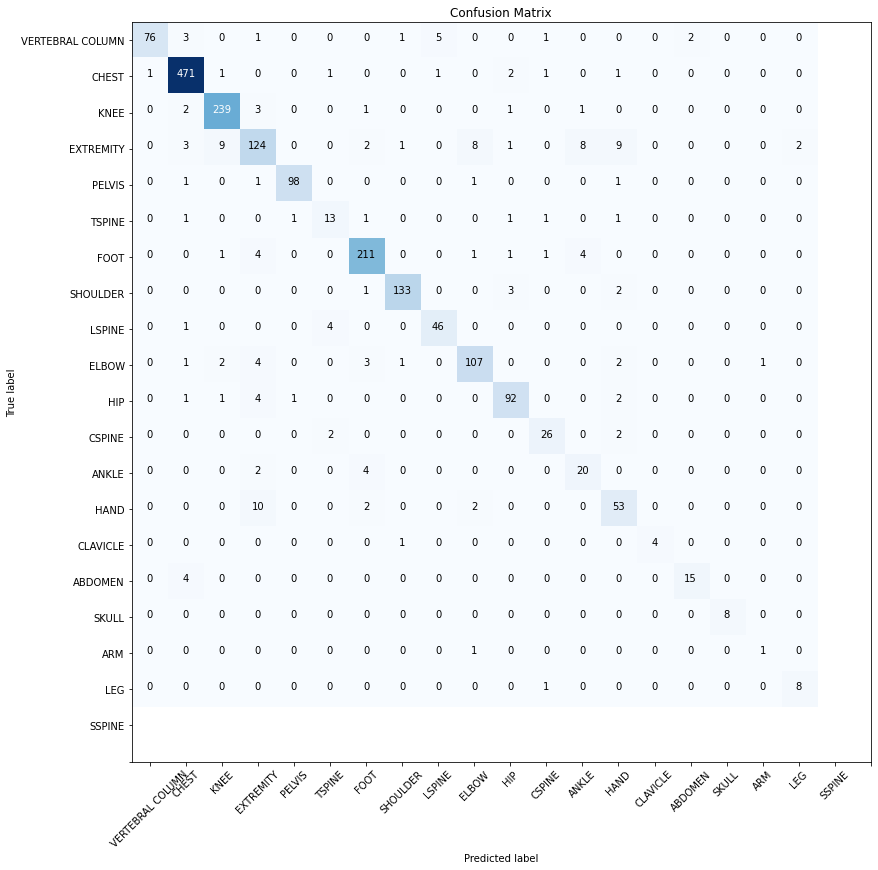

In [7]:
node.classifier.evaluate(testsubset, verbosity=2, plot_cm=True)